In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.ndimage import gaussian_filter1d
from sklearn.linear_model import LinearRegression
from scipy.special import legendre
from photometry_functions import airPLS, get_zdFF

In [3]:
sns.set_style('ticks')
sns.set_context('talk')
import warnings; warnings.simplefilter('ignore')

In [4]:
data_dir = '/home/julia/data/ict/'

### Load one trial

In [22]:
#mouse = 'TAY'
mouse = 'UUU'
#day = -5
day= 0
df = pd.read_pickle(data_dir+'mice/{}.pkl'.format(mouse))

In [6]:
trial = 20
raw_signal = df[(df['day']==day)]['gpmt'].iloc[trial]
raw_reference = df[(df['day']==day)]['rpmt'].iloc[trial]

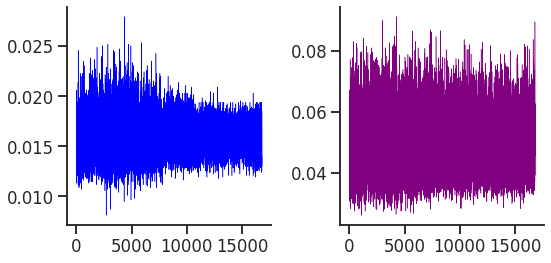

In [7]:
fig = plt.figure(figsize=(8, 4))
ax1 = fig.add_subplot(121)
ax1.plot(raw_signal,'blue',linewidth=0.5)
ax2 = fig.add_subplot(122)
ax2.plot(raw_reference,'purple',linewidth=0.5)
plt.tight_layout()
sns.despine()

# Step by step -- adapted

### Smooth

In [12]:
smooth_signal = gaussian_filter1d(raw_signal, sigma=100, output=np.float64)
smooth_reference = gaussian_filter1d(raw_reference, sigma=100, output=np.float64)

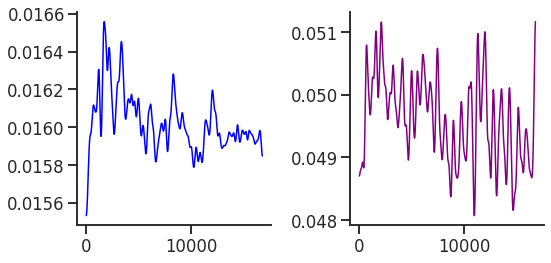

In [13]:
fig = plt.figure(figsize=(8, 4))
ax1 = fig.add_subplot(121)
ax1.plot(smooth_signal,'blue',linewidth=1.5)
ax2 = fig.add_subplot(122)
ax2.plot(smooth_reference,'purple',linewidth=1.5)
plt.tight_layout()
sns.despine()

### Remove beginning and end

In [69]:
remove = 1000
short_signal = smooth_signal[remove:-remove]
short_reference = smooth_reference[remove:-remove]

### Linear regression to fit baseline

In [70]:
predict_signal = airPLS(short_signal, lambda_=4e5, porder=1, itermax=50)
predict_reference = airPLS(short_reference, lambda_=4e5, porder=1, itermax=50)

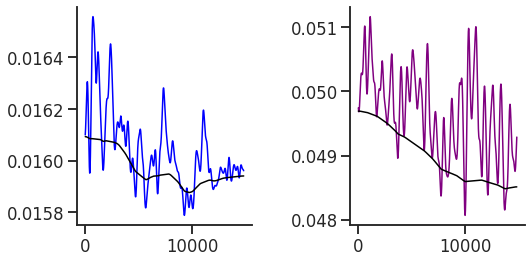

In [71]:
fig = plt.figure(figsize=(8, 4))
ax1 = fig.add_subplot(121)
ax1.plot(short_signal,'blue',linewidth=1.5)
ax1.plot(predict_signal,'black',linewidth=1.5)
ax2 = fig.add_subplot(122)
ax2.plot(short_reference,'purple',linewidth=1.5)
ax2.plot(predict_reference,'black',linewidth=1.5)
plt.tight_layout()
sns.despine()

### Remove baseline

In [72]:
signal = short_signal - predict_signal 
reference = short_reference - predict_reference

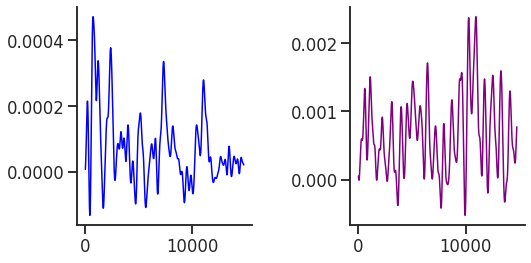

In [73]:
fig = plt.figure(figsize=(8, 4))
ax1 = fig.add_subplot(121)
ax1.plot(signal,'blue',linewidth=1.5)
ax2 = fig.add_subplot(122)
ax2.plot(reference,'purple',linewidth=1.5)
plt.tight_layout()
sns.despine()

### Standardize signal

In [74]:
z_reference = (reference - np.median(reference)) / np.std(reference)
z_signal = (signal - np.median(signal)) / np.std(signal)

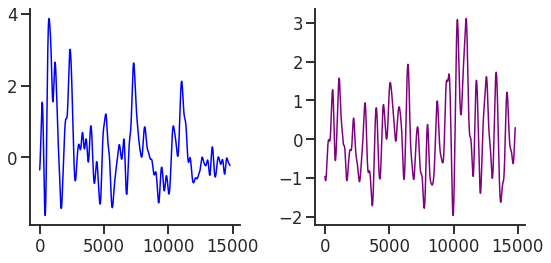

In [75]:
fig = plt.figure(figsize=(8, 4))
ax1 = fig.add_subplot(121)
ax1.plot(z_signal,'blue',linewidth=1.5)
ax2 = fig.add_subplot(122)
ax2.plot(z_reference,'purple',linewidth=1.5)
plt.tight_layout()
sns.despine()

### Fit signals using linear regression

from sklearn.linear_model import Lasso
lin = Lasso(alpha=0.0001,precompute=True,max_iter=1000,
            positive=True, random_state=9999, selection='random')
n = len(z_reference)
lin.fit(z_reference.reshape(n,1), z_signal.reshape(n,1))
z_reference_fitted = lin.predict(z_reference.reshape(n,1)).reshape(n,)

In [76]:
lin = LinearRegression()
n = len(z_reference)
lin.fit(z_reference.reshape(n,1), z_signal.reshape(n,1))
z_reference_fitted = lin.predict(z_reference.reshape(n,1)).reshape(n,)
zdFF = (z_signal - z_reference_fitted)

In [77]:
idx=np.arange(0,z_signal.shape[0],100)

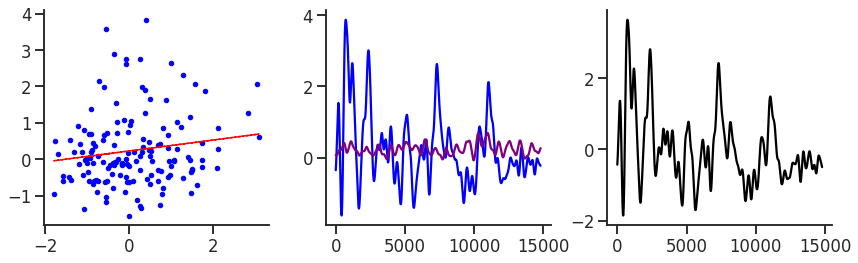

In [78]:
fig = plt.figure(figsize=(12, 4))
ax1 = fig.add_subplot(131)
ax1.plot(z_reference[idx],z_signal[idx],'b.', linewidth=0)
ax1.plot(z_reference[idx],z_reference_fitted[idx], 'r--',linewidth=1.5)

ax2 = fig.add_subplot(132)
ax2.plot(z_signal,'blue')
ax2.plot(z_reference_fitted,'purple')

ax3 = fig.add_subplot(133)
ax3.plot(zdFF,'black')

plt.tight_layout()
sns.despine()